In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')


In [2]:
# Load the dataset (adjust path if needed)
df = pd.read_csv('../raw_data/air_fare_raw.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head(5)

Dataset shape: (12781, 10)

First 5 rows:


,Airline,Departure_Time,Arrival_Time,Duration,Departure,Destination,Date,Total_Stops,SClass,Price
0,VietJet Air,18:00,19:20,80,HAN,DAD,15-04-2025,0,ECONOMY,1147900
1,VietJet Air,21:05,22:25,80,HAN,DAD,15-04-2025,0,ECONOMY,1147900
2,Vietravel Airlines,17:55,19:10,75,HAN,DAD,15-04-2025,0,ECONOMY,1188800
3,Bamboo Airways,19:50,21:20,90,HAN,DAD,15-04-2025,0,ECONOMY,1253000
4,Vietravel Airlines,07:25,08:45,80,HAN,DAD,15-04-2025,0,ECONOMY,1397800


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12781 entries, 0 to 12780
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Airline         12781 non-null  object
 1   Departure_Time  12781 non-null  object
 2   Arrival_Time    12781 non-null  object
 3   Duration        12781 non-null  int64 
 4   Departure       12781 non-null  object
 5   Destination     12781 non-null  object
 6   Date            12781 non-null  object
 7   Total_Stops     12781 non-null  int64 
 8   SClass          12781 non-null  object
 9   Price           12781 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 998.6+ KB


In [4]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,12781.0,2.586766e+02,2.076683e+02,45.0,90.0,130.0,410.0,1055.0
Total_Stops,12781.0,4.443314e-01,5.267227e-01,0.0,0.0,0.0,1.0,3.0
Price,12781.0,3.439932e+06,2.107961e+06,589000.0,2020000.0,3058000.0,4342000.0,14603000.0


## Trích xuất các thông tin từ cột Departure_Time, Arrival_Time và Date

In [5]:
df[['Departure_Time', 'Arrival_Time']] = df[['Departure_Time', 'Arrival_Time']].apply(pd.to_datetime)
df['Date'] = (pd.to_datetime(df['Date'], dayfirst=True, format='%d-%m-%Y')).dt.day

In [6]:
def extract_hour(data, col):
    data[col.replace('_Time', '') + '_Hour'] = data[col].dt.hour
    
def extract_min(data, col):
    data[col.replace('_Time', '') + '_Min'] = data[col].dt.minute
    
def drop_col(data, col):
    data.drop(col, axis = 1, inplace=True)

In [7]:
extract_hour(df,'Departure_Time')
extract_min(df,'Departure_Time')
drop_col(df,'Departure_Time')

extract_hour(df,'Arrival_Time')
extract_min(df,'Arrival_Time')
drop_col(df,'Arrival_Time')

In [8]:
df.head(5)

,Airline,Duration,Departure,Destination,Date,Total_Stops,SClass,Price,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min
0,VietJet Air,80,HAN,DAD,15,0,ECONOMY,1147900,18,0,19,20
1,VietJet Air,80,HAN,DAD,15,0,ECONOMY,1147900,21,5,22,25
2,Vietravel Airlines,75,HAN,DAD,15,0,ECONOMY,1188800,17,55,19,10
3,Bamboo Airways,90,HAN,DAD,15,0,ECONOMY,1253000,19,50,21,20
4,Vietravel Airlines,80,HAN,DAD,15,0,ECONOMY,1397800,7,25,8,45


## Tách các biến trong DataFrame df thành hai nhóm: biến định lượng (quantitative) và biến định tính (qualitative) dựa trên kiểu dữ liệu của chúng.

In [9]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('Price')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

## Trực quan hóa dữ liệu

### 1. Phân bố dữ liệu của **PRICE**

<Axes: xlabel='Price'>

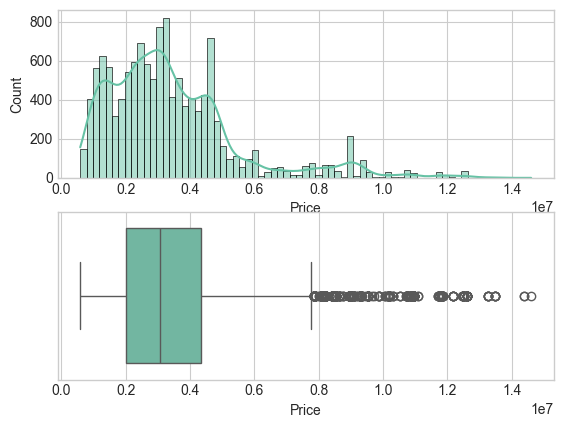

In [10]:
fig, (ax1,ax2) = plt.subplots(2,1)
sns.histplot(df['Price'], kde=True, ax=ax1)
sns.boxplot(x=df['Price'], ax=ax2)

- Giá trị của biến Price tập trung trong khoảng từ 2.000.000 - 4.000.000 VND. Tuy nhiên vẫn còn xuất hiện nhiều ngoại lệ, điều này có thể xuất phát từ sự chênh lệch giá của các hạng vé khác nhau.

### 2. Phân tích các biến định lượng - **Departure_Time**, **Arrival_Time**, **Date**, **Duration** và **Total_Stops**

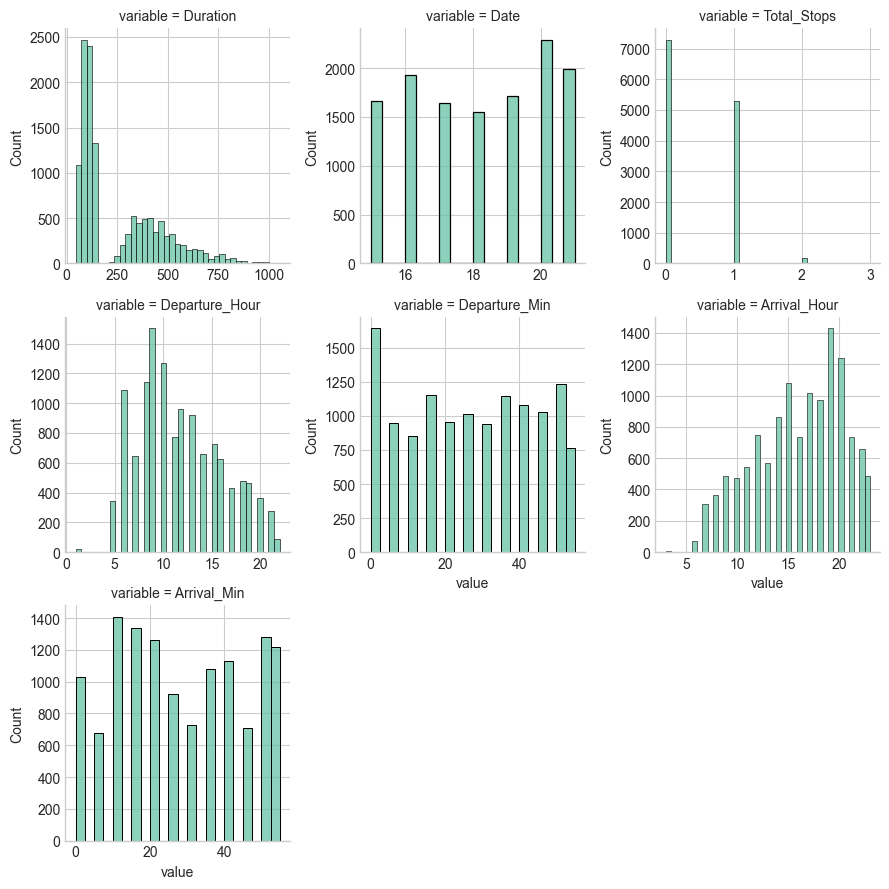

In [11]:
f = pd.melt(df, value_vars=quantitative)
grid = sns.FacetGrid(f, col='variable',  col_wrap=3, sharex=False, sharey=False)
grid = grid.map(sns.histplot, 'value')

### Nhận xét về phân bố các biến định lượng

- **Duration**: Phân bố có độ lệch phải rõ rệt, đa số chuyến bay có thời gian bay dưới 200 phút, với một số ít chuyến bay kéo dài hơn.

- **Date**: Phân bố tương đối đều trong khoảng từ ngày 15 đến ngày 21, thể hiện việc thu thập dữ liệu đều đặn trong khoảng 1 tuần.

- **Total_Stops**: Đa số các chuyến bay không có điểm dừng (giá trị 0), một số ít có 1 điểm dừng.

- **Departure_Hour**: Phân bố tập trung vào các khung giờ cao điểm: sáng sớm (5-8h), trưa (11-13h) và chiều tối (17-20h). Điều này phản ánh lịch trình bay thông thường tại Việt Nam.

- **Departure_Min**: Phân bố không đều, tập trung ở một số phút cụ thể (0, 5, 10, 15, ...) cho thấy các chuyến bay thường được lên lịch vào các thời điểm tròn giờ hoặc nửa giờ.

- **Arrival_Hour**: Phân bố tương tự như giờ khởi hành, tập trung vào các khung giờ cụ thể trong ngày.

- **Arrival_Min**: Cũng tập trung ở các mốc phút cụ thể, với phân bố không đều tương tự như Departure_Min.

- Dữ liệu biến Duration tập trung phần lớn ở khoảng dưới 200. Trong khoảng này, giá trị biến Price phân tán trong khoảng 1.000.000 đến 6.000.000 VND. Nhìn chung, sự tương quan của hai biến này không quá rõ.

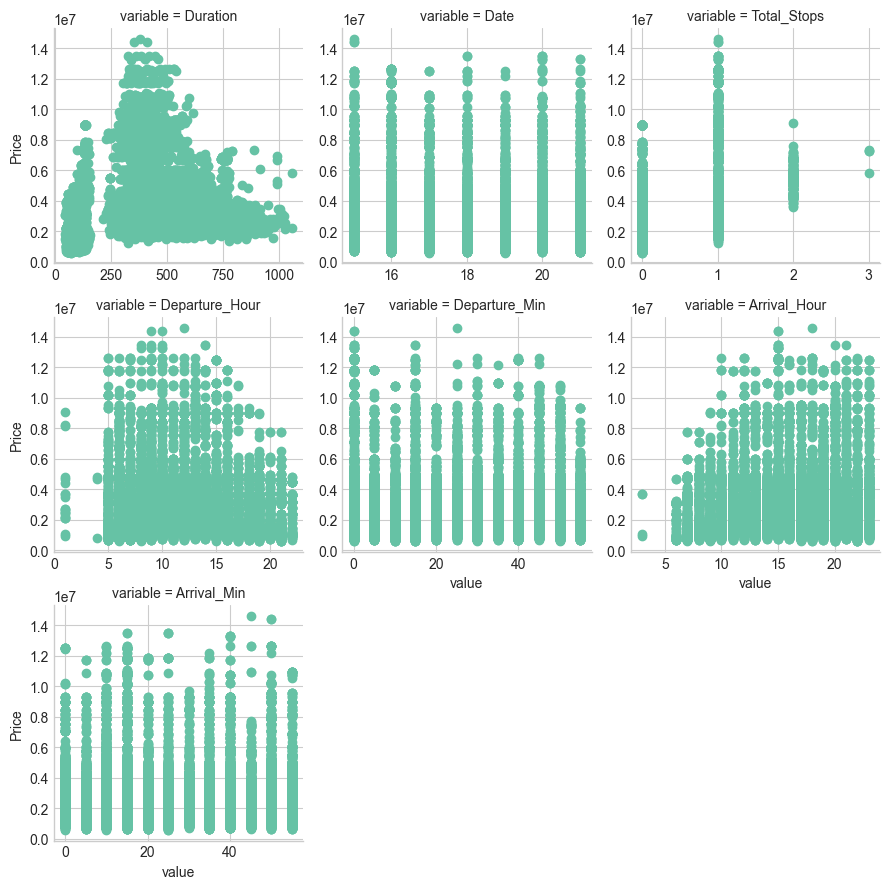

In [12]:
f = pd.melt(df, id_vars=['Price'], value_vars=quantitative)
grid = sns.FacetGrid(f, col='variable',  col_wrap=3, sharex=False, sharey=False)
grid = grid.map(plt.scatter, 'value', 'Price')

## Nhận xét tương quan giữa Price và các biến định lượng

Từ các biểu đồ scatter plot, có thể rút ra những nhận xét sau:

- **Duration**: Có xu hướng tương quan dương với Price - chuyến bay dài hơn thường có giá cao hơn, đặc biệt khi thời gian bay vượt quá 300 phút.

- **Date**: Không thể hiện mối tương quan rõ ràng với Price. Giá vé phân tán đều ở tất cả các ngày.

- **Total_Stops**: Chuyến bay có điểm dừng (giá trị 1) có xu hướng đắt hơn so với chuyến bay thẳng (giá trị 0).

- **Departure_Hour/Min và Arrival_Hour/Min**: Không có mối tương quan tuyến tính rõ ràng, tuy nhiên có thể nhận thấy một số khung giờ nhất định (sáng sớm và tối) có xu hướng giá cao hơn.

Nhìn chung, Duration và Total_Stops có ảnh hưởng rõ rệt nhất đến giá vé, trong khi các biến thời gian khác có ảnh hưởng phức tạp hơn, có thể phụ thuộc vào sự kết hợp với các yếu tố khác.

### 3. Phân tích các biến định tính - **Departure**, **Destination**, **Airline**,  và **SClass**

<Axes: ylabel='Airline'>

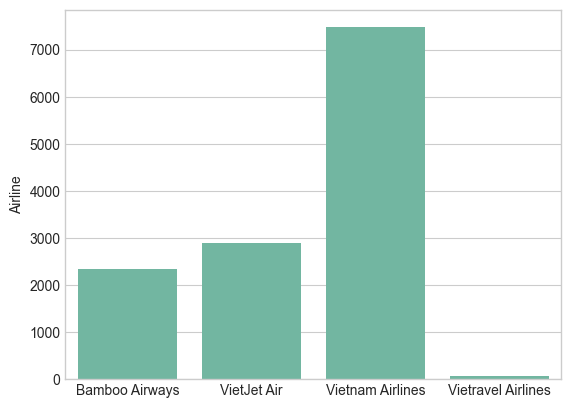

In [13]:
sns.barplot(x=sorted(df.Airline.unique()), y=df.groupby('Airline')['Airline'].count())

- VietNam Airlines cung cấp nhiều chuyến bay nhất, trong khi đó, số lượng chuyến bay mà BamBoo Airways và Vietjet Air cung cấp gần như tương đương và Vietravel Airlines cung cấp ít chuyến bay nhất.

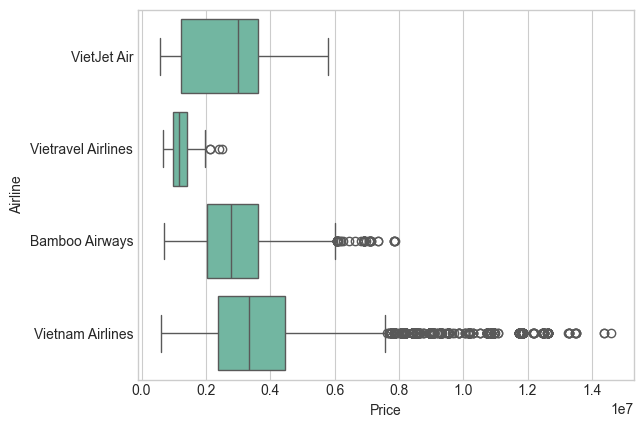

In [14]:
sns.boxplot(data=df, x='Price', y='Airline')
plt.show()

- Giá vé máy bay của Vietnam Airline tập trung trong khoảng từ 2.000.000 VND đến hơn 4.000.000 VND và xuất hiện khá nhiều ngoại lệ, điều này xảy ra vì mức giá của hạng Business của hãng này cao đột biến so với các hạng còn lại.
- Giá vé máy bay của Bamboo Airways tập trung trong khoảng giữa 2.000.000 VND và 3.500.000 VND và vẫn còn xuất hiện một ít ngoại lệ.
- Giá vé của Vietjet Air tập trung trong khoảng từ hơn 1.000.000 VND đến khoảng 4.500.000 VND.
- Vietravel cung cấp khá ít chuyến bay nên giá vé máy bay của hãng này chỉ tập trung xung quanh khoảng 1.000.000 VND.

<Axes: xlabel='Airline', ylabel='Price'>

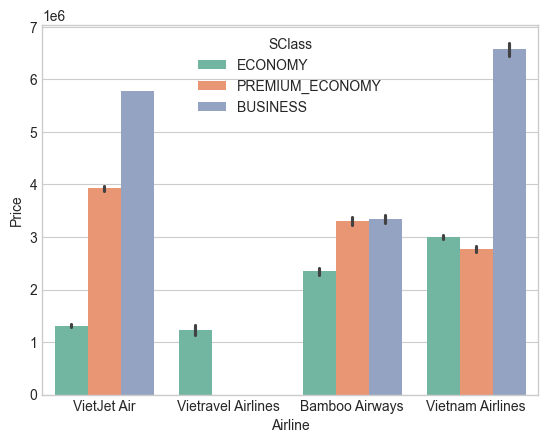

In [15]:
sns.barplot(data=df, x="Airline", y="Price", hue="SClass")

## Nhận xét về mối quan hệ giữa Hãng bay, Hạng vé và Giá vé

- **Vietnam Airlines** có mức giá cao nhất ở tất cả các hạng vé, đặc biệt hạng Business có giá cao đáng kể so với các hãng khác (trên 8.000.000 VND).

- **Bamboo Airways** có mức giá trung bình ở hạng Economy và Premium Economy, nhưng giá hạng Business khá cao, chỉ thấp hơn Vietnam Airlines.

- **VietJet Air** cung cấp mức giá cạnh tranh nhất ở hạng Economy và Premium Economy. Hãng này không có dữ liệu cho hạng Business trong dataset.

- **Vietravel Airlines** có mức giá thấp nhất ở hạng Economy, tạo lợi thế cạnh tranh cho phân khúc du lịch giá rẻ. Hãng này cũng không có dữ liệu cho hạng Business.

- Sự chênh lệch giá giữa các hạng vé rất rõ rệt, với Business Class có giá cao gấp nhiều lần so với Economy, đặc biệt ở Vietnam Airlines.

In [16]:
# create subplots
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=False,
                    shared_yaxes=True, horizontal_spacing=0)

fig.append_trace(go.Bar(y=sorted(df.Departure.unique()),
                     x=df.groupby('Departure')['Departure'].count(),
                     orientation='h', 
                     width=0.7, 
                     showlegend=False, 
                     marker_color='#4472c4'), 
                     1, 1) 

fig.append_trace(go.Bar(y=sorted(df.Destination.unique()),
                     x=df.groupby('Destination')['Destination'].count(), 
                     textposition='inside',
                     orientation='h', 
                     width=0.7, 
                     showlegend=False, 
                     marker_color='#ed7d31'), 
                     1, 2) 
fig.update_xaxes(showticklabels=False,title_text='Departure', row=1, col=1, range=[10000,0])
fig.update_xaxes(showticklabels=False,title_text='Destination', row=1, col=2)

fig.update_layout(title_text="Departure vs Destination", 
                  width=800, 
                  height=700,
                  title_x=0.9,
                  xaxis1={'side': 'top'},
                  xaxis2={'side': 'top'})

try:
    fig.show()
except ValueError as e:
    if "nbformat" in str(e):
        print("Error: nbformat>=4.2.0 is required for Plotly visualizations.")
        print("Please run: pip install nbformat>=4.2.0")
        print("\nAlternatively, you can use matplotlib for visualization:")
        
        # Create alternative visualization using matplotlib
        plt.figure(figsize=(14, 10))
        
        plt.subplot(1, 2, 1)
        plt.barh(sorted(df.Departure.unique()), df.groupby('Departure')['Departure'].count(), color='#4472c4')
        plt.title('Departure')
        plt.gca().invert_xaxis()
        
        plt.subplot(1, 2, 2)
        plt.barh(sorted(df.Destination.unique()), df.groupby('Destination')['Destination'].count(), color='#ed7d31')
        plt.title('Destination')
        
        plt.suptitle('Departure vs Destination')
        plt.tight_layout()
        plt.show()
    else:
        # If it's some other error, re-raise it
        raise e

## Nhận xét về phân bố cặp điểm đi/điểm đến

Từ biểu đồ so sánh giữa điểm đi (Departure) và điểm đến (Destination), có thể rút ra những nhận xét sau:

- **Sân bay phổ biến**: SGN (Tân Sơn Nhất) và HAN (Nội Bài) là những sân bay được sử dụng nhiều nhất cả làm điểm đi và điểm đến, phản ánh vai trò của hai trung tâm kinh tế lớn nhất Việt Nam.

- **Sự cân bằng**: Có sự cân bằng tương đối giữa số lượng chuyến bay xuất phát và đến tại các sân bay lớn, thể hiện luồng di chuyển hai chiều đều đặn.

- **Sân bay thứ cấp**: DAD (Đà Nẵng), PQC (Phú Quốc) và CXR (Cam Ranh) cũng có lượng chuyến bay đáng kể, phản ánh sức hút của các điểm du lịch nổi tiếng.

- **Sân bay khu vực**: Các sân bay như PXU (Pleiku), UIH (Qui Nhơn), VDO (Vân Đồn) có lượng chuyến bay ít hơn, chủ yếu phục vụ nhu cầu đi lại địa phương.

- **Mất cân đối**: Một số sân bay như BMV (Buôn Ma Thuột), VCS (Côn Đảo), VCL (Chu Lai) có sự chênh lệch giữa lượng chuyến bay đi và đến, có thể do đặc thù khai thác hoặc nhu cầu thị trường.

<Axes: ylabel='Departure'>

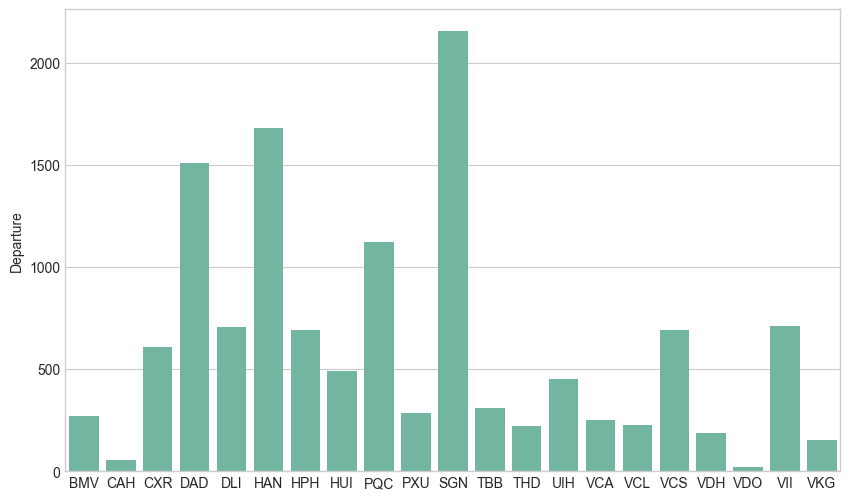

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(x=sorted(df.Departure.unique()), y=df.groupby('Departure')['Departure'].count())

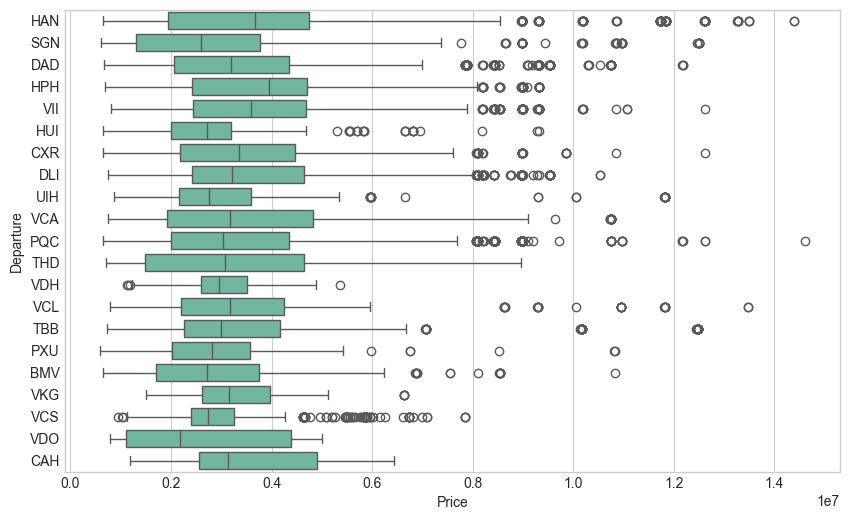

In [18]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=df, x='Price', y='Departure')

<Axes: ylabel='Destination'>

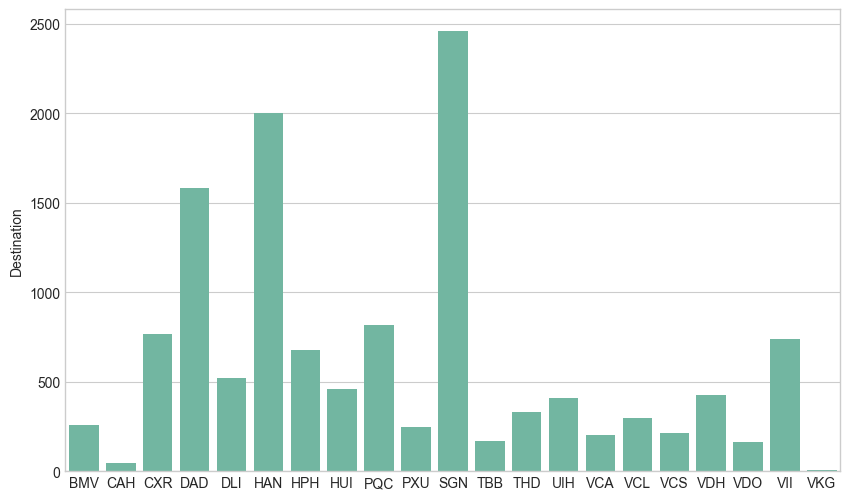

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(x=sorted(df.Destination.unique()), y=df.groupby('Destination')['Destination'].count())

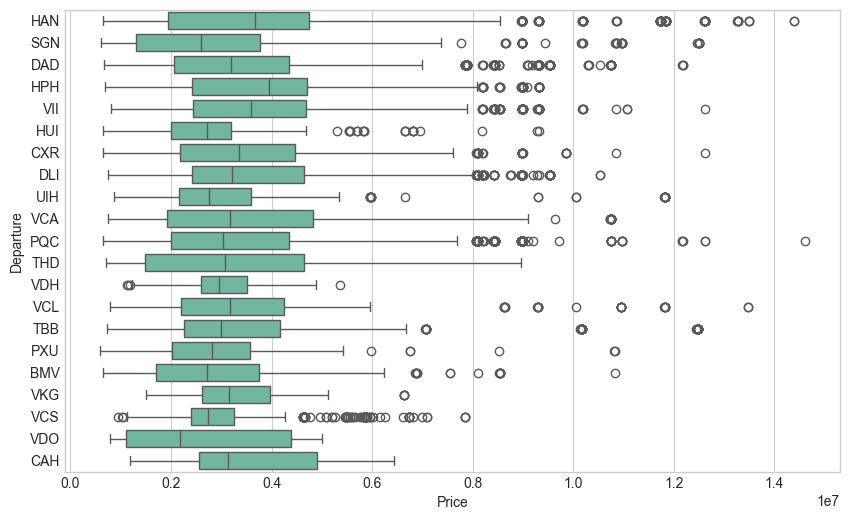

In [20]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=df, x='Price', y='Departure')

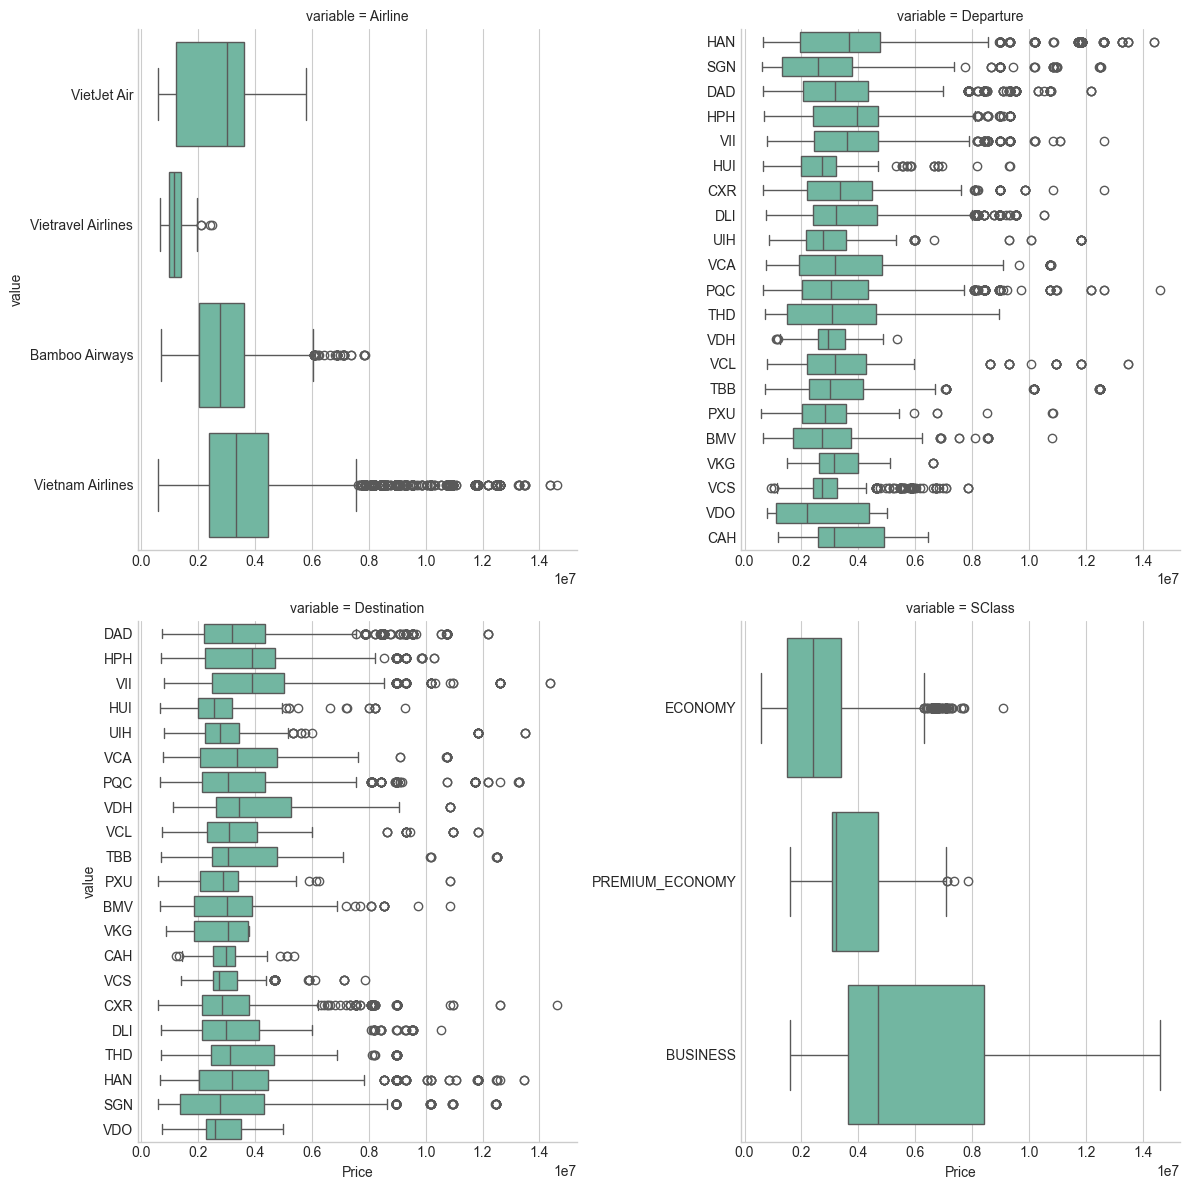

In [21]:
def boxplot(x, y, **kwargs):
  sns.boxplot(x=x, y=y)


f = pd.melt(df, id_vars=['Price'], value_vars=qualitative)
g = sns.FacetGrid(f, col='variable',  col_wrap=2, sharex=False, sharey=False, height=6)
g = g.map(boxplot, 'Price', 'value')

## Nhận xét tổng quan về phân tích dữ liệu vé máy bay

### Phân bố giá vé (Price)
- Giá vé tập trung chủ yếu trong khoảng 2-4 triệu VND, với nhiều giá trị ngoại lệ cao hơn
- Sự phân tán giá vé phụ thuộc mạnh vào hạng vé (SClass) và hãng hàng không (Airline)

### Các yếu tố chính ảnh hưởng đến giá vé
1. **Hãng hàng không**: Vietnam Airlines có mức giá cao nhất, đặc biệt ở hạng Business; Vietravel có giá thấp nhất ở hạng Economy
2. **Hạng vé**: Business Class có giá cao gấp nhiều lần so với Economy và Premium Economy
3. **Thời gian bay (Duration)**: Chuyến bay dài hơn thường có giá cao hơn
4. **Số điểm dừng (Total_Stops)**: Chuyến bay có điểm dừng có xu hướng đắt hơn chuyến bay thẳng

### Đặc điểm về thời gian bay
- Thời gian khởi hành tập trung ở các khung giờ cao điểm: sáng sớm (5-8h), trưa (11-13h) và chiều tối (17-20h)
- Phần lớn chuyến bay có thời gian bay dưới 200 phút
- Lịch trình bay thường được xếp vào các thời điểm tròn giờ hoặc nửa giờ

### Đặc điểm về điểm đi/đến
- Sân bay HAN (Hà Nội) và SGN (TP.HCM) là những điểm đi/đến phổ biến nhất
- Mức giá vé giữa các cặp điểm đi/đến có sự chênh lệch đáng kể, phản ánh nhu cầu thị trường

## 4. Tương quan dữ liệu

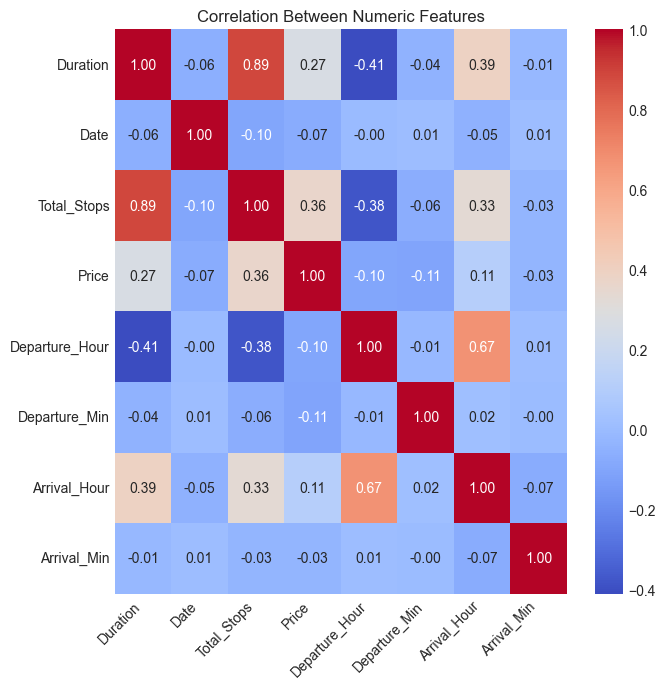

In [22]:
# Calculate correlation for only numeric columns
plt.figure(figsize = (7, 7))

# Filter to only include numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Create correlation matrix and plot heatmap
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Numeric Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Nhận xét về ma trận tương quan

Từ ma trận tương quan của các biến số, có thể rút ra những nhận xét quan trọng sau:

### Các biến có tương quan đáng kể với giá vé (Price):
- **Total_Stops**: Có tương quan dương mạnh nhất với Price (0.36), cho thấy số điểm dừng càng nhiều, giá vé càng cao.
- **Duration**: Có tương quan dương khá rõ với Price (0.27), thể hiện rằng chuyến bay càng dài thì giá vé thường càng cao.
- **Arrival_Hour**: Có tương quan dương nhẹ (0.11), cho thấy giờ đến khuya có thể liên quan đến giá vé cao hơn.
- **Departure_Hour** và **Departure_Min**: Có tương quan âm nhẹ (-0.10), gợi ý rằng một số giờ khởi hành sáng sớm có thể có giá vé rẻ hơn.